In [1]:
%load_ext autoreload

# Enable autoreload for all modules
%autoreload 2

import sys
sys.path.append("..")


from collections import Counter
from torchvision.models import resnet18, ResNet18_Weights, efficientnet_b3, EfficientNet_B3_Weights
from torchvision import transforms
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from loader import image_loader
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score

from utils import prep

In [2]:
import wandb

In [2]:
torch.cuda.empty_cache()

In [43]:
torch.randint(4, (1,)).item()

3

In [2]:
# Define your data transformations (modify as needed)
transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


transform_train = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.Lambda(lambda img: transforms.functional.rotate(img, angle=90 * torch.randint(4, (1,)).item())),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


train_dataset = image_loader.CNNImageLoader("/media/data/alex_johannes/octa_data/Cairo/SCP_images",
                                         "/media/data/alex_johannes/octa_data/Cairo/labels.csv",
                                         transform=transform_train,
                                         mode = "train"
                                         )
test_dataset = image_loader.CNNImageLoader("/media/data/alex_johannes/octa_data/Cairo/SCP_images",
                                         "/media/data/alex_johannes/octa_data/Cairo/labels.csv",
                                         transform=transform_test,
                                         mode = "val"
                                         )
                                        


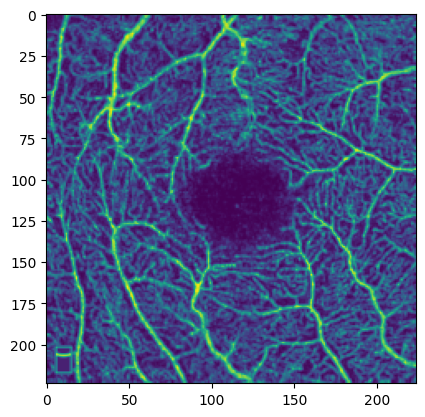

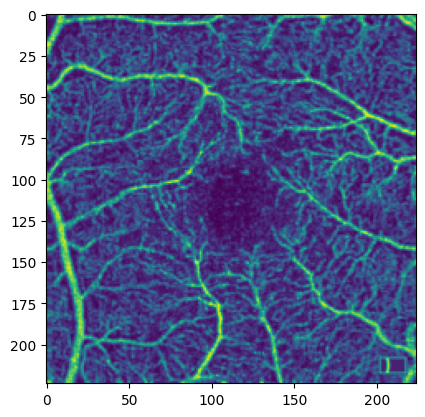

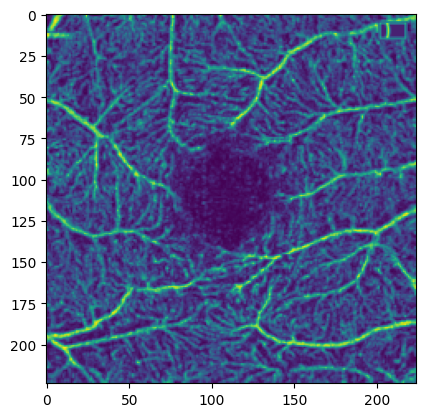

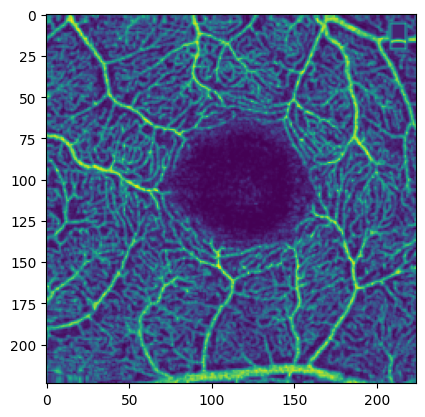

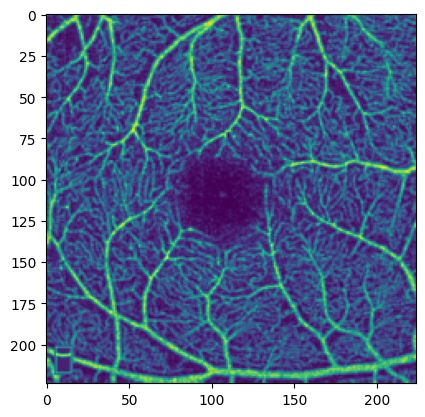

In [4]:
lim = 0 
for data in train_dataset:
    lim+=1
    plt.imshow(np.array(data[0])[2,:,:])
    plt.show()
    if lim == 5:
        break

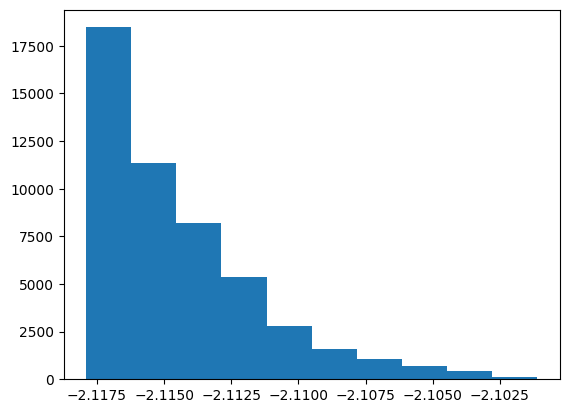

In [36]:
for data in train_dataset:
    plt.hist(np.array(data[0][0,:,:]).flatten())
    break

In [33]:
for data in train_dataset:
    print(data[0].shape)
    print(data[1])
    print(data[0])
    break

torch.Size([3, 224, 224])
0
tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044

In [4]:
# Get the labels from the training dataset
train_labels = [label for _, label in train_dataset]
class_weights = prep.get_class_weights(train_labels, verbose = True)

Label distribution in the training set:
Class 0: 691 samples
Class 2: 141 samples
Class 1: 67 samples
Class weights for balanced CrossEntropyLoss:
Class 0: Weight 0.43367100820067533
Class 2: Weight 2.1252955082742315
Class 1: Weight 4.472636815920398


In [8]:


run = wandb.init(project="graph_pathology")

run.name = "EfficientNet_B3_Weights.DEFAULT"

# Load the pre-trained ResNet18 model
#weights = ResNet18_Weights.DEFAULT
#model = resnet18(weights=weights)

weights = EfficientNet_B3_Weights.DEFAULT
model = efficientnet_b3(weights=weights)

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Modify the last fully connected layer to match the number of classes in your task
num_classes = 3  # Change this to the number of classes in your dataset
#model.fc = nn.Linear(model.fc.in_features, num_classes)
model.classifier._modules['1'] = nn.Linear(model.classifier._modules['1'].in_features, num_classes)

# Define your loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights).to(device))
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


# Training loop
num_epochs = 50 
model.to(device)


batch_size = 32  
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=1)
test_loader = DataLoader(dataset=test_dataset, batch_size=1, shuffle=False, num_workers=1)

for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    # get the test loss and accuracy

    test_loss = 0.0
    model.eval()  # prep model for evaluation

    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = criterion(output, target)
        test_loss += loss.item() * data.size(0)

    # calculate avg test loss
    test_loss = test_loss / len(test_loader.dataset)

    train_accuracy, train_balanced_accuracy = prep.evaluate_cnn(model, train_loader)
    test_accuracy, test_balanced_accuracy = prep.evaluate_cnn(model, test_loader)

    #print(f"Test Accuracy: {accuracy}, Test Balanced Accuracy: {balanced_accuracy}")

    #print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {loss.item()} ,Test Loss: {test_loss}")
    wandb.log({"loss": loss, "train_acc": train_accuracy, "test_acc": test_accuracy, "test_bal_acc": test_balanced_accuracy})

    #if (epoch+1) % 2 == 0:
    #    # print the accuracy and balanced accuracy for the test set
#
    #    accuracy, balanced_accuracy = prep.evaluate_cnn(model, test_loader)
    #    print(f"Test Accuracy: {accuracy}, Test Balanced Accuracy: {balanced_accuracy}")



# Save the fine-tuned model if needed
#torch.save(resnet.state_dict(), 'fine_tuned_resnet18.pth')

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: luxtu. Use `wandb login --relogin` to force relogin


KeyboardInterrupt: 